In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib 
import cv2
import numpy as np

Reading the image and converting it to Gray scale
----------------------


(480, 720, 3)


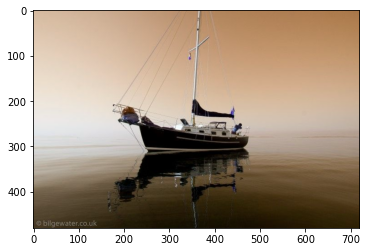

In [2]:
img = cv2.imread("sample_image.jpg",1)
h,w,c = img.shape
print(img.shape)
plt.imshow(img)

480 720


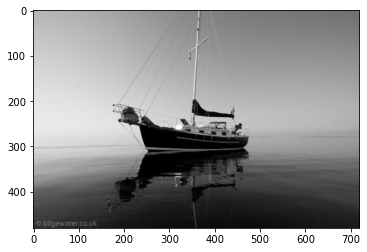

In [4]:
Gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(Gray_image,cmap = "gray")
h,w = Gray_image.shape
print(h,w)
#print(Gray_image[0])

Get the Squared image
----------

In [6]:
def getSquaredImage(img) :
    h,w = img.shape
    squared_image = np.zeros((h,w))
    for i in range(len(img)) :
        for j in range(len(img[i])) :
            squared_image[i][j] = pow(img[i][j], 2)
    return squared_image        

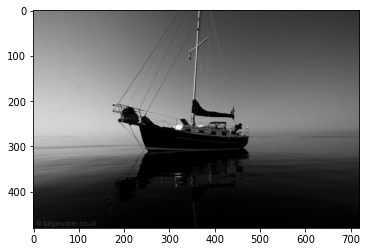

In [8]:
squared_Image = getSquaredImage(Gray_image)
plt.imshow(squared_Image,cmap = "gray")

Find the Integeral Image for the original and squared image
------------

The below method calculates a new matrix with comulative sum for each row

In [9]:
def getSumOfRows(img) :
    h,w =img.shape
    comulative_sum_rows = np.zeros((h,w))
    for i in range(len(img)) :
        sum = 0
        for j in range(len(img[i])) :
            sum += img[i][j]
            comulative_sum_rows[i][j] = sum
    return comulative_sum_rows       

In [11]:
def integralArray(img) :
    h,w =img.shape
    comulative_sum_rows = getSumOfRows(img)
    Integral_Image = np.zeros((h,w))
    for i in range(len(comulative_sum_rows[0])) :
        sum = 0
        for j in range(len(comulative_sum_rows)) :
            sum += comulative_sum_rows[j][i]
            Integral_Image[j][i] = sum
        
    return Integral_Image    

Here is the integral image for the original image

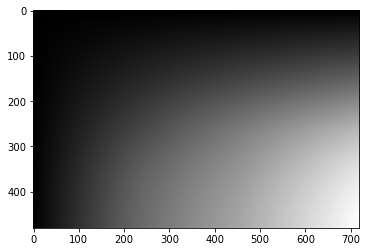

In [14]:
Integral_Image = integralArray(Gray_image)
plt.imshow(Integral_Image, cmap = "gray")

Here is the integral image for the squared image

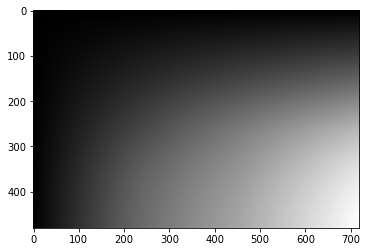

In [15]:
Integral_Squared_Image = integralArray(getSquaredImage(Gray_image))
plt.imshow(Integral_Image, cmap = "gray")

Find the local sum of pixels in a specific area
---------

In [16]:
def localSum(img, n0, m0, n, m):
    s = img[n][m]
    up = 0
    left = 0
    diagonal = 0
    if (isValid(n0-1,m)) : 
        up = img[n0-1][m]
    if (isValid(n, m0-1)) :
        left = img[n][m0-1]
    if (isValid(n0-1 ,m0-1)) :
        diagonal = img[n0-1][m0-1]
    
    sum = s - up - left + diagonal
    return sum

In [17]:
def isValid(x, y):
    if x >= 0 and y >= 0 :
        return True
    else :
        return False

In [18]:
sum = localSum(out,0,0,4,4)
print(sum)

4540.0


Find the image with edge detection using the variance between the intgeral matrix of original and squared image
-------------------

In [19]:
def imgWithIntegral(img, ww, wh):
    h,w = img.shape
    N = ww * wh
    Integral_Image = integralArray(img)
    Integral_Squared_Image = integralArray(getSquaredImage(img))
    out = np.zeros((h,w))
    for i in range(h - wh) :
        for j in range(w - ww) :
            n0 = i
            m0 = j
            n = wh + n0 -1
            m = ww + m0 -1
            NormalSum = localSum(Integral_Image,n0,m0,n,m)
            SquaredSum = localSum(Integral_Squared_Image,n0,m0,n,m)
            var = (int)(Variance(N, SquaredSum, NormalSum))
            if(var < 750):
                var = 0
            #if (var > 750) :
             #   print(var)
              #  var = 255
            cx = (int)((n0+n)/2)
            cy = (int)((m0+m)/2)
            out[cx][cy] = var
    return out      

In [20]:
def Variance(N, SquaredSum, NormalSum):
    term1 = (1/N) * SquaredSum
    term2 = pow((1/N) *NormalSum,2)
    var = term1 - term2
    return var

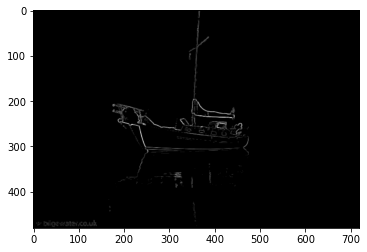

In [21]:
out = imgWithIntegral(Gray_image, 3, 3)
plt.imshow(out, cmap = "gray")

Now, Applying some threshold to the output image

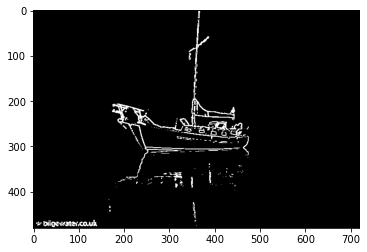

In [22]:
_,out_WithThreshold = cv2.threshold(out, 750, 255, cv2.THRESH_BINARY)
plt.imshow(out_WithThreshold, cmap = "gray")

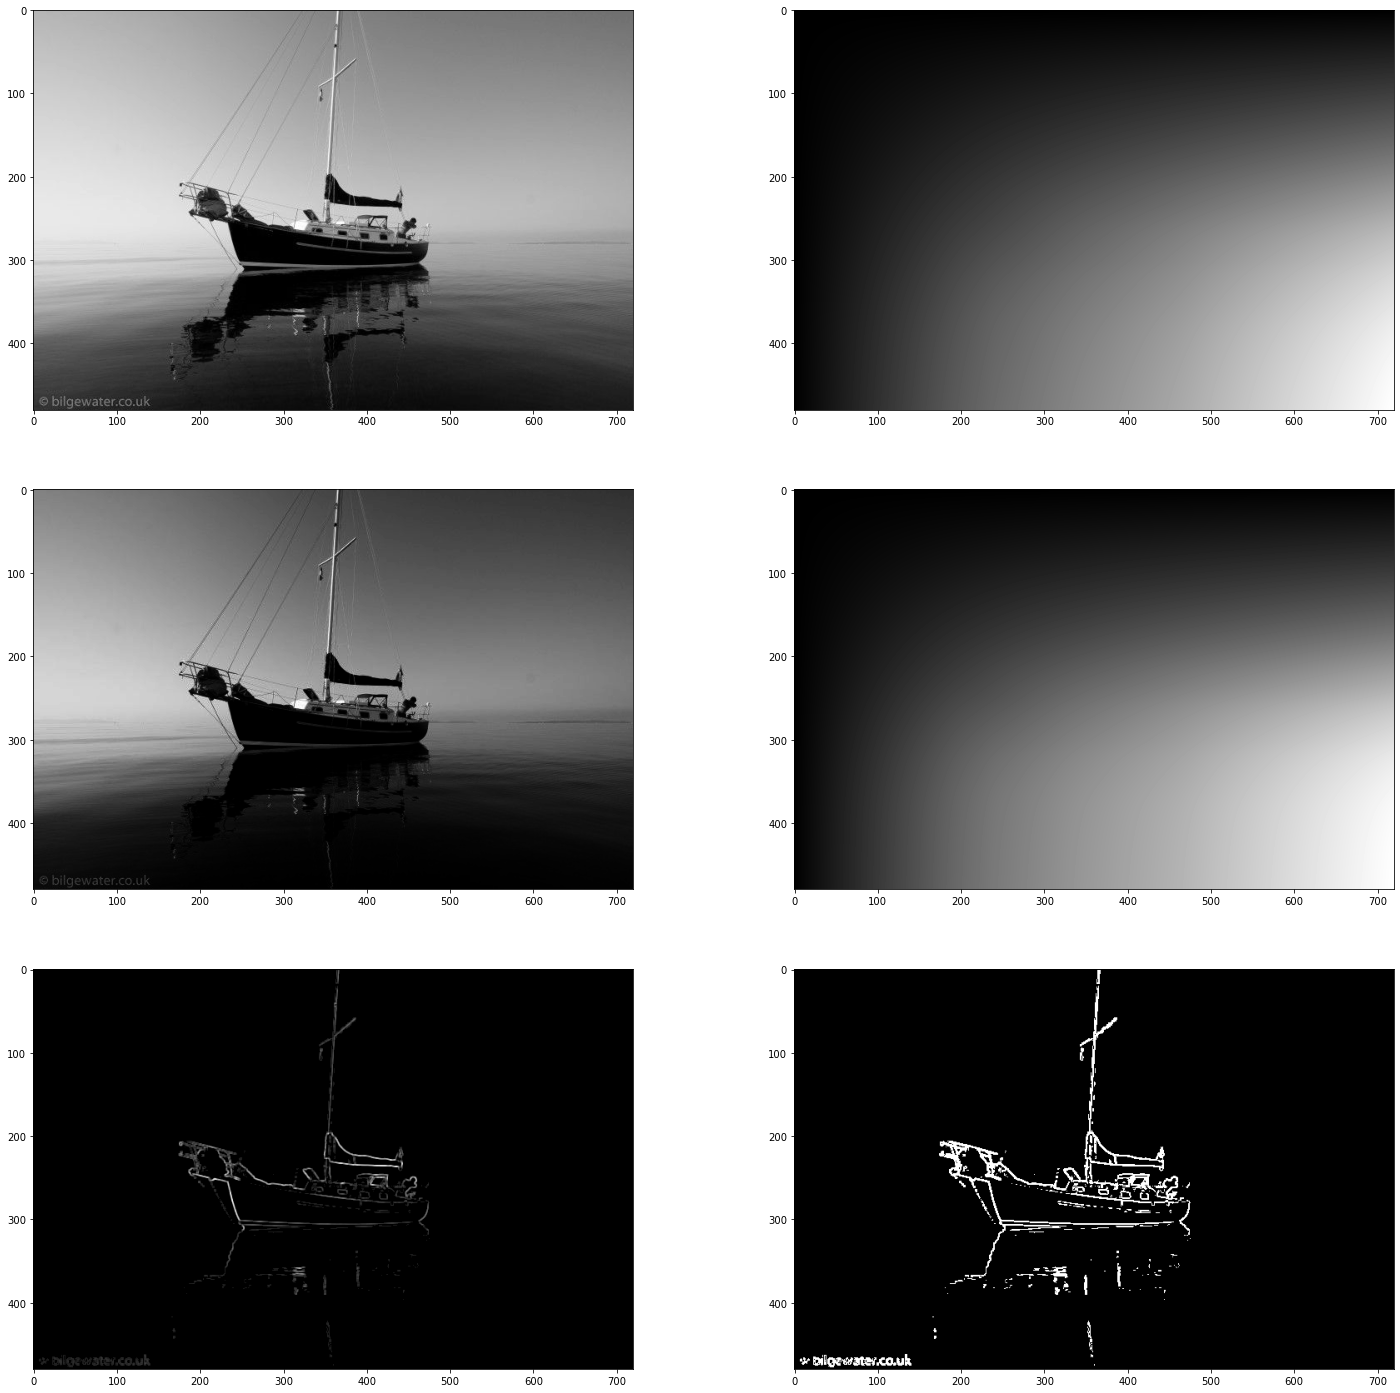

In [24]:
plt.subplots(nrows=3, ncols=2, figsize=(25, 25))

plt.subplot(3,2,1)
plt.imshow(Gray_image,  cmap = 'gray')

plt.subplot(3,2,2)
plt.imshow(Integral_Image,  cmap = 'gray')

plt.subplot(3,2,3)
plt.imshow(squared_Image,  cmap = 'gray')

plt.subplot(3,2,4)
plt.imshow(Integral_Squared_Image,  cmap = 'gray')

plt.subplot(3,2,5)
plt.imshow(out,  cmap = 'gray')

plt.subplot(3,2,6)
plt.imshow(out_WithThreshold,  cmap = 'gray')

Some Comments
----------

Let's talk first about the complexity of the each function :

      1-integralArray    ----> O(n*m), as we need first to calculate the comulative sum of each raw,
                               and this will cost us O(n*m), and then we need to calculate the comulative
                               sum for each row, which is also O(n*m), so the whole integralArray function
                               the time complexity will be O(n*m), and the space complexity will be the same
                               to store the new generated matrix.
                            
      2-localSum         ----> O(1), as all we need is the image and the boundaries of the rectangle, 
                               and then we will get pixel values at (n,m),(n,m0-1),(n0-1,m) and (n0-1,m0-1),
                               and getting each value of them will cost us O(1).
          
      3-imgWithIntegral  ----> In this function, first we need to calculate the integral image for 
                               the original and squared image, and this will cost us O(n*m) as we 
                               said before, where n,m are the dimensions of the image.
                               After that, we need to do some sliding window to calculate the variances
                               between the integral of both original and squared, and this will cost us
                               O((n-wh) * (m-ww)), where n,m are the height and width of the image, and
                               wh,ww are the given height and width of the window, so the whole time
                               complexity will be : O(n*m) + O((n-wh) * (n-ww)), which can be considered
                               as O(n*m), and the space complexity will aslo be O(n*m). 
                               This complexity can be enhanced a little bit if we add the integral of 
                               both the original and squared image as parameters to the function itself,
                               so we do not have to calculate them again inside the function. In this case 
                               the complexity will be : O((n-wh) * (m-ww))
                               
Now, let's talk about the efficiency of the output
 
       The Algorithm is very powerful for edge detection, but the problem is that some thin lines 
       disappeared after applying it, and these thin lines can be considered as edges. However, the algorithm
       can detect the main edges of the given image efficiently. Also, the algorithm has another disadvantage
       which is the time complexity.
       
       